In [273]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
#Libraries to evaluate the face recognition system's performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

### Part 1: Dataset Selection and Preprocessing (15 points)

#### Testing pre-processing and face detection on one file

Set the default image dimensions

In [274]:
nrows = 64
ncolumns = 64

Specify the directory with the Yale faces and non-faces

In [275]:
yalefaces_dir = 'yalefaces'
nonfaces_dir = 'non_faces'

Load the data from the **yalefaces** directory

In [276]:
def load_images(imagedirectory):
    image_list = []
    for i, imagefile in enumerate(os.listdir(imagedirectory)):
        image = Image.open(os.path.join(imagedirectory, imagefile))
        image = image.resize((nrows, ncolumns))
        image_list.append(np.asarray(image.getdata()))
    return image_list

Flatten the data

In [277]:
X = np.asarray(load_images(yalefaces_dir))

In [278]:
X.shape

(165, 4096)

### Part 2: Eigenface Generation (20 points)

Calculate the average face image

In [279]:
# Get the length of the images array
length_dataset = X.shape[0]

mean_face = np.sum(X, axis=0, dtype='float64') / length_dataset

Find the mean matrix using the numpy tile function. np.tile constructs an array by repeating a given dataset by the number of times specified

In [280]:
mean_matrix = np.tile(mean_face, (length_dataset, 1))

Mean-center the image data. Mean-centering calculates the difference between the mean value and the actual value, ensuring that we are only looking at the variance in the dataset

In [292]:
X_centered = X - mean_matrix

Caclulate the co-variance in the data. Convariance is a measure of the relationship between two variables.

In this case, we calculate the co-variance by finding the dot product of the image data and a transposed version of the image data

In [293]:
covariance_matrix = (X_centered.dot(X_centered.T)) / length_dataset

Find the eigenvalues and eigenvectors using the covariance matrix. Because they are square and symmetrical, covariance matrixes are diagonalizable, which means an eigendecomposition can be performed on the matrix.

In [294]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

Convert the eigenvalues and eigenvectors from complex numbers to real numbers

In [295]:
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

Find the order of the eignevalues

In [296]:
order = np.real(eigenvalues).argsort()[::-1]

Sort the eigenvalues by their order

In [297]:
eigenvalues = eigenvalues[order]

Get the principal components

In [298]:
eigenvectors_C = eigenvectors[:, order]

Project all images to the eigen space

In [299]:
eigenvectors_C = X_centered.T @ eigenvectors 

Normalize all the eigenfaces

In [300]:
eigenfaces = preprocessing.normalize(eigenvectors_C.T)

Plot the first eigenface

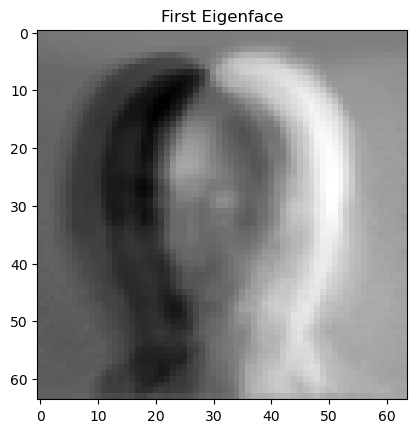

In [301]:
plt.imshow(np.resize(eigenfaces[0], (nrows,ncolumns)), cmap='gray')
plt.title('First Eigenface')
plt.show()

### Part 3: Face Recognition (35 points)

Get the recounstruction error to determine the initial number of components to use

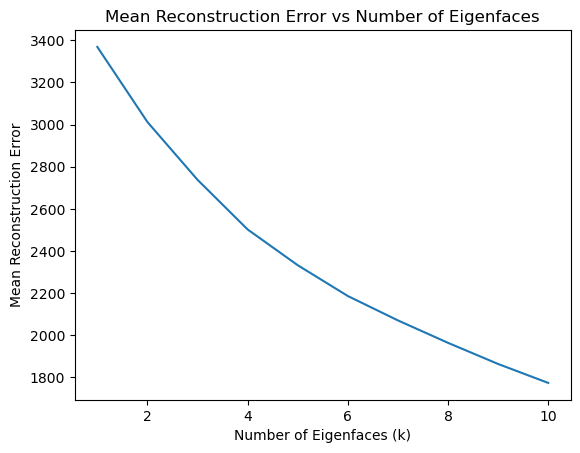

Mean reconstruction error using k=10: 1773.56261683575


In [302]:
errors = []

for k in range(1, 11):
    error_sum = 0
    for F in X:
        omega = eigenfaces[:k].dot(F - mean_face)
        F_reconstructed = eigenfaces[:k].T.dot(omega) + mean_face
        error = np.linalg.norm(F - F_reconstructed)
        error_sum += error
    mean_error = error_sum / X.shape[0]
    errors.append(mean_error)

plt.plot(range(1, 11), errors)
plt.xlabel('Number of Eigenfaces (k)')
plt.ylabel('Mean Reconstruction Error')
plt.title('Mean Reconstruction Error vs Number of Eigenfaces')
plt.show()

print(f"Mean reconstruction error using k=10: {errors[9]}")

From the above graph we can deduce that 10 or more Eigenfaces represent the same data, as the the mean reconstruction error reduces towards a straight line. Therefore, we will start with the number of components as 10, and then compare the performance as the number of components increases

In [304]:
num_components = 10

Create a function to project an image to the eigenspace

In [305]:
def project_to_eigenspace(image, eigen_faces, mean_face):
    return eigen_faces.dot(image - mean_face)

Create a function to find the cosine similarity between two matrices

In [306]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

Create a function to find the maximum similarity between an image projection and the set of eigen faces

In [307]:
def compute_max_similarity(image_projection, eigen_faces, num_components):
    eigen_projections = [project_to_eigenspace(ef, eigen_faces, mean_face) for ef in eigen_faces[:num_components]]
    similarities = [cosine_similarity(image_projection, ep) for ep in eigen_projections]
    
    return np.max(similarities)

Define a function to determine if an image contains a face

In [308]:
def is_face(image, eigen_faces, mean_face, num_components, threshold = 0.5):
    image_projection = project_to_eigenspace(image, eigen_faces, mean_face)
    max_similarity = compute_max_similarity(image_projection, eigen_faces[:num_components], num_components)
    return max_similarity > threshold

Check if an image is a face

In [309]:
given_image = Image.open('non_faces/B1_00002.pgm')
given_image = given_image.resize((nrows, ncolumns))

# Convert the given image into a numpy array
given_image = np.asarray(given_image.getdata())

# Get the face evaluation result
result = is_face(given_image, eigenfaces[:num_components], mean_face, num_components)
if result:
    print("The image is a face")
else:
    print("The image is not a face")

The image is a face


Check the difference between the actual mean face and predicted mean faces

In [310]:
true_label = []
predicted_label = []

for i, imagefile in enumerate(os.listdir(yalefaces_dir)):
    true_label.append(1)
    new_image = Image.open(os.path.join(yalefaces_dir, imagefile))
    new_image = new_image.resize((nrows, ncolumns))
    new_image = np.asarray(new_image.getdata())
    if is_face(new_image, eigenfaces[:num_components], mean_face, num_components):
        predicted_label.append(1)
    else:
        predicted_label.append(0)

In [311]:
# Loop through the non-faces
for i, image_file in enumerate(os.listdir(nonfaces_dir)):
    true_label.append(0)
    new_image = Image.open(os.path.join(nonfaces_dir, image_file))
    new_image = new_image.resize((nrows, ncolumns))
    new_image = np.asarray(new_image.getdata())
    
    if is_face(new_image, eigenfaces[:num_components], mean_face, num_components):
        predicted_label.append(1)
    else:
        predicted_label.append(0)

Print the evaluation metrics

In [312]:
score = accuracy_score(true_label, predicted_label)
f1 = f1_score(true_label, predicted_label)
print(f"Accuracy score is {score}")
print(f"F1 score is {f1}")

Accuracy score is 0.09381237524950099
F1 score is 0.05809128630705395


### Part 4: Experimentation and Analysis (20 points)

Define a function to calculate the accuracy with a varying number of components using the logic defined above

In [313]:
def get_accuracy_score(num_components, faces_directory, non_faces_directory):
    # Loop through the faces
    for i, image_file in enumerate(os.listdir(faces_directory)):
        # Label the file as a face
        true_label.append(1)
        new_image = Image.open(os.path.join(faces_directory, image_file))
        new_image = new_image.resize((nrows, ncolumns))
        new_image = np.asarray(new_image.getdata())

        if is_face(new_image, eigenfaces[:num_components], mean_face, num_components):
            predicted_label.append(1)
        else:
            predicted_label.append(0)
        
    # Loop through the non-faces
    for i, image_file in enumerate(os.listdir(non_faces_directory)):
        # Label the file as a face
        true_label.append(0)
        new_image = Image.open(os.path.join(non_faces_directory, image_file))
        new_image = new_image.resize((nrows, ncolumns))
        new_image = np.asarray(new_image.getdata())

        if is_face(new_image, eigenfaces[:num_components], mean_face, num_components):
            predicted_label.append(1)
        else:
            predicted_label.append(0)
            
    #Compute the accuracy and F1 scores
    score = accuracy_score(true_label, predicted_label)
    f1 = f1_score(true_label, predicted_label)
    # Return the four computed metrics
    return score, f1     

Create a loop that checks the accuracy for an increasing number of components

In [314]:
# Create lists to hold the metrics
evaluation_scores = []
for num_components in range(1, 50, 5):
    score, f1 = get_accuracy_score(num_components, yalefaces_dir, nonfaces_dir)
    evaluation_scores.append([num_components, score, f1])

Print the results in a table

In [315]:
table = evaluation_scores
print(tabulate(table, headers=["Number of Components", "Accuracy Score", "F1 Score"]))

  Number of Components    Accuracy Score    F1 Score
----------------------  ----------------  ----------
                     1         0.127745    0.157996
                     6         0.111111    0.127937
                    11         0.106786    0.111221
                    16         0.104192    0.100962
                    21         0.102794    0.0940544
                    26         0.101796    0.0890688
                    31         0.101048    0.0853008
                    36         0.100466    0.0823529
                    41         0.0998004   0.0795918
                    46         0.099256    0.0773234


**Conclusion**

In [ ]:
diff = 0.633763 - 0.612679
round(diff, 4)

As the number of components of components increases, the accuracy of the model only shows slight increment. For example with 26 components, the accuracy score is 0.612679 while with 86 components, the accuracy is 0.633763. The difference in accuracy score between using 26 and 86 components is approximately 0.0211. 

Therefore, we can conclude that the number of components increases, the algorithm has already extracted the most relevant information from the faces with the initial set of features and the new images being added are not adding more information to the algorithm

We can also conclude that the model will perform as well when using the initial number of components which was 5

#### Strengths of Eignefaces

- Raw intensity data are used directly for learning and recognition without any significant low-level or mid-level processing
- No knowledge of geometry and reflectance of faces is required
- Data compression is achieved by the low-dimensional subspace representation
- Recognition is simple and efficient compared to other matching approaches.

#### Limitations of Eignefaces